In [1]:
import os
import pandas
import json
import pickle

import numpy
import math

%matplotlib widget
import matplotlib
import matplotlib.pyplot
import seaborn

import datetime
import pytz

import activity_experiments_python.scenario_management as SFM
import activity_experiments_python.ampconfig_management as ACM
import activity_experiments_python.signalsconfig_management as SCM
import activity_experiments_python.actuation_management as AM

In [2]:
# CONSTANTS
FPS             = 30 # Hz
NB_ACTS         = 8
MAPPING         = {0:[0,0], 1:[0,1], 2:[0,2], 3:[0,3], 4:[1,3], 5:[1,2], 6:[1,1], 7:[1,0]}
ACTUATION_DUR   = 15 # secs

# PATHS
root_path = "/Users/matthieu/Documents/proto3/Graz2023/May/activity/continuous/"

conf_path = root_path + 'configs/'
amp_config_file = conf_path + 'amp2config/config.json'
sig_config_file = conf_path + 'signals/signals_config.json'
sce_alloc_file = root_path + 'processed_data/scenarios_allocation.json'

res_path = root_path + 'processed_data/acts/'
leds_res_path = res_path + 'leds/'
acts_res_path = res_path + 'acts/'

# CONFIGS
amp_conf        = ACM.extract_amp_config(amp_config_file)
sig_conf        = SCM.extract_signals_config(sig_config_file)

f = open(sce_alloc_file, "r")
sce_alloc = json.load(f)
f.close()


# DATA
file_list = [x for x in os.listdir(acts_res_path) if x.endswith('acts.pickle')]
exps_times_list = sorted(list(set([x.split('_')[0] for x in file_list])))

resdata = [] 
for exp_id, exp_time in enumerate(exps_times_list):
    datapt = {}
    datapt['time'] = pytz.utc.localize(datetime.datetime.strptime(exp_time[:-3], '%y%m%dT%H%M%S'))
    datapt['time_hr'] = exp_time
    datapt['act_path'] = acts_res_path
    datapt['led_path'] = leds_res_path
    for i in range(0, NB_ACTS+1):
        if i == NB_ACTS:
            ind = 'a'
        else :
            ind = str(i)
        datapt['z'+ind+'_actname'] = exp_time+'_z'+ind+'_acts.pickle'
    datapt['led0name'] = exp_time + '_led0.pickle'
    datapt['led1name'] = exp_time + '_led1.pickle'

    # print(sce_alloc[exp_time])
    sce = SFM.extract_scenario_data_from_log(root_path + sce_alloc[exp_time])
    trig0_val = numpy.min(sce[2])
    trig1_val = numpy.min(sce[3])
    
    datapt['trig0'] = trig0_val
    datapt['trig1'] = trig1_val
    if trig0_val == 11 :
        datapt['sig1'] = {}
        datapt['sig2'] = {}
    else :
        datapt['sig1'] = sig_conf['SB0'][str(trig0_val)]['1']
        datapt['sig2'] = sig_conf['SB0'][str(trig0_val)]['2']

    if trig1_val == 11 :
        datapt['sig3'] = {}
        datapt['sig4'] = {}
    else :
        datapt['sig3'] = sig_conf['SB1'][str(trig1_val)]['1']
        datapt['sig4'] = sig_conf['SB1'][str(trig1_val)]['2']

    list_of_freqs = []
    for i in range(0, 8):
        ind = str(i)
        datapt['z'+ind+'_sig'] = [x for x in amp_conf.keys() if i in amp_conf[x]][0]
        if not(datapt['z'+ind+'_sig'] == 'gnd') and not(datapt[datapt['z'+ind+'_sig']] == {}):
            datapt['z'+ind+'_freq'] = datapt[datapt['z'+ind+'_sig']]['frequency']
            list_of_freqs.append(datapt['z'+ind+'_freq'])
        else :
            datapt['z'+ind+'_freq'] = None

    if trig1_val*trig0_val == 121 :
        datapt['frequency'] = 'Ctrl'
    elif trig1_val >= trig0_val:
        datapt['frequency'] = sig_conf['SB0'][str(trig0_val)]
    else :
        datapt['frequency'] = sig_conf['SB1'][str(trig1_val)]
    
    # sanity check
    if len(set(list_of_freqs)) > 1:
        print('Multiple frequencies at the same time')
        datapt['frequency'] = 'Problem'
    elif len(set(list_of_freqs)) == 1:
        datapt['frequency'] = list_of_freqs[0]
    else :
        datapt['frequency'] = 'Ctrl'
        
    resdata.append(datapt)

metadata = pandas.DataFrame.from_dict(resdata)
metadata

,time,time_hr,act_path,led_path,z0_actname,z1_actname,z2_actname,z3_actname,z4_actname,z5_actname,...,z3_freq,z4_sig,z4_freq,z5_sig,z5_freq,z6_sig,z6_freq,z7_sig,z7_freq,frequency
0,2023-05-28 08:00:12+00:00,230528T080012UTC,/Users/matthieu/Documents/proto3/Graz2023/May/...,/Users/matthieu/Documents/proto3/Graz2023/May/...,230528T080012UTC_z0_acts.pickle,230528T080012UTC_z1_acts.pickle,230528T080012UTC_z2_acts.pickle,230528T080012UTC_z3_acts.pickle,230528T080012UTC_z4_acts.pickle,230528T080012UTC_z5_acts.pickle,...,NaN,sig2,1750.0,sig2,1750.0,sig4,1750.0,sig4,1750.0,1750
1,2023-05-28 08:02:11+00:00,230528T080211UTC,/Users/matthieu/Documents/proto3/Graz2023/May/...,/Users/matthieu/Documents/proto3/Graz2023/May/...,230528T080211UTC_z0_acts.pickle,230528T080211UTC_z1_acts.pickle,230528T080211UTC_z2_acts.pickle,230528T080211UTC_z3_acts.pickle,230528T080211UTC_z4_acts.pickle,230528T080211UTC_z5_acts.pickle,...,NaN,sig2,NaN,sig2,NaN,sig4,NaN,sig4,NaN,1500
2,2023-05-28 08:04:11+00:00,230528T080411UTC,/Users/matthieu/Documents/proto3/Graz2023/May/...,/Users/matthieu/Documents/proto3/Graz2023/May/...,230528T080411UTC_z0_acts.pickle,230528T080411UTC_z1_acts.pickle,230528T080411UTC_z2_acts.pickle,230528T080411UTC_z3_acts.pickle,230528T080411UTC_z4_acts.pickle,230528T080411UTC_z5_acts.pickle,...,NaN,sig2,NaN,sig2,NaN,sig4,NaN,sig4,NaN,Ctrl
3,2023-05-28 08:06:11+00:00,230528T080611UTC,/Users/matthieu/Documents/proto3/Graz2023/May/...,/Users/matthieu/Documents/proto3/Graz2023/May/...,230528T080611UTC_z0_acts.pickle,230528T080611UTC_z1_acts.pickle,230528T080611UTC_z2_acts.pickle,230528T080611UTC_z3_acts.pickle,230528T080611UTC_z4_acts.pickle,230528T080611UTC_z5_acts.pickle,...,1250.0,sig2,NaN,sig2,NaN,sig4,NaN,sig4,NaN,1250
4,2023-05-28 08:08:11+00:00,230528T080811UTC,/Users/matthieu/Documents/proto3/Graz2023/May/...,/Users/matthieu/Documents/proto3/Graz2023/May/...,230528T080811UTC_z0_acts.pickle,230528T080811UTC_z1_acts.pickle,230528T080811UTC_z2_acts.pickle,230528T080811UTC_z3_acts.pickle,230528T080811UTC_z4_acts.pickle,230528T080811UTC_z5_acts.pickle,...,NaN,sig2,NaN,sig2,NaN,sig4,2000.0,sig4,2000.0,2000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
802,2023-06-12 10:10:11+00:00,230612T101011UTC,/Users/matthieu/Documents/proto3/Graz2023/May/...,/Users/matthieu/Documents/proto3/Graz2023/May/...,230612T101011UTC_z0_acts.pickle,230612T101011UTC_z1_acts.pickle,230612T101011UTC_z2_acts.pickle,230612T101011UTC_z3_acts.pickle,230612T101011UTC_z4_acts.pickle,230612T101011UTC_z5_acts.pickle,...,NaN,sig2,1500.0,sig2,1500.0,sig4,1500.0,sig4,1500.0,1500
803,2023-06-12 10:12:11+00:00,230612T101211UTC,/Users/matthieu/Documents/proto3/Graz2023/May/...,/Users/matthieu/Documents/proto3/Graz2023/May/...,230612T101211UTC_z0_acts.pickle,230612T101211UTC_z1_acts.pickle,230612T101211UTC_z2_acts.pickle,230612T101211UTC_z3_acts.pickle,230612T101211UTC_z4_acts.pickle,230612T101211UTC_z5_acts.pickle,...,1000.0,sig2,1000.0,sig2,1000.0,sig4,1000.0,sig4,1000.0,1000
804,2023-06-12 10:14:11+00:00,230612T101411UTC,/Users/matthieu/Documents/proto3/Graz2023/May/...,/Users/matthieu/Documents/proto3/Graz2023/May/...,230612T101411UTC_z0_acts.pickle,230612T101411UTC_z1_acts.pickle,230612T101411UTC_z2_acts.pickle,230612T101411UTC_z3_acts.pickle,230612T101411UTC_z4_acts.pickle,230612T101411UTC_z5_acts.pickle,...,NaN,sig2,1750.0,sig2,1750.0,sig4,NaN,sig4,NaN,1750
805,2023-06-12 10:16:11+00:00,230612T101611UTC,/Users/matthieu/Documents/proto3/Graz2023/May/...,/Users/matthieu/Documents/proto3/Graz2023/May/...,230612T101611UTC_z0_acts.pickle,230612T101611UTC_z1_acts.pickle,230612T101611UTC_z2_acts.pickle,230612T101611UTC_z3_acts.pickle,230612T101611UTC_z4_acts.pickle,230612T101611UTC_z5_acts.pickle,...,1250.0,sig2,NaN,sig2,NaN,sig4,NaN,sig4,NaN,1250


In [3]:
def euclidean_dist(x, y):
    return (x[0]-y[0])**2 + (x[1]-y[1])**2

def find_closest_act(dtpt, i_act):
    dist_init = 100
    closest_act = 10
    for i in range(NB_ACTS):
        ind = str(i)
        if dtpt['act_z'+ind] == 1 :
            dist = euclidean_dist(MAPPING[i_act], MAPPING[i])
            if dist < dist_init :
                closest_act = i
                dist_init = dist
                
    return closest_act, dist_init

In [4]:
# Activity computation
long_interval_length    = 15 # seconds 
short_interval_length   = 5 # seconds 


lil_dt = datetime.timedelta(seconds=long_interval_length)
sil_dt = datetime.timedelta(seconds=short_interval_length)

fields_to_keep = ['time', 'time_hr', 'frequency', 'trig0', 'trig1']
resdata = []
for exp_id, exp in metadata.iterrows():
    datapoint = {}
    for key in fields_to_keep:
        datapoint[key] = exp[key]

    sum_acts = 0
    for i in range(0, NB_ACTS):
        if not(math.isnan(exp['z'+str(i)+'_freq'])):
            datapoint['act_z'+str(i)] = 1
            sum_acts += 1
        else :
            datapoint['act_z'+str(i)] = 0
    for i in range(0, NB_ACTS):
        close_act, dist = find_closest_act(datapoint, i)
        datapoint['act_z'+str(i)+'_closest_act_dist'] = dist
    
    datapoint['nb_acts_active'] = sum_acts
    led0_signal = pandas.read_pickle(exp.led_path + exp.led0name)
    led1_signal = pandas.read_pickle(exp.led_path + exp.led1name)
    
    sce = SFM.extract_scenario_data_from_log(root_path + sce_alloc[datapoint['time_hr']])

    if exp.trig0*exp.trig1 == 121:
        ts = 0
        ct = 17
    elif exp.trig0 == 11:
        ts = SFM.compute_time_shift(led1_signal.value, sce[1], plot=False, save_plot_fname=None, fps=FPS)
        ct = 1/FPS*next((i for i, x in enumerate(list(sce[1])) if x==0), None) + ts/FPS
    elif exp.trig1 == 11:
        ts = SFM.compute_time_shift(led0_signal.value, sce[0], plot=False, save_plot_fname=None, fps=FPS)
        ct = 1/FPS*next((i for i, x in enumerate(list(sce[0])) if x==0), None) + ts/FPS
    else:
        ts0 = SFM.compute_time_shift(led0_signal.value, sce[0], plot=False, save_plot_fname=None, fps=FPS)
        ts1 = SFM.compute_time_shift(led1_signal.value, sce[1], plot=False, save_plot_fname=None, fps=FPS)
        ts = (ts0 + ts1) / 2
        ct = 1/FPS*next((i for i, x in enumerate(list(sce[0])) if x==0), None) + ts/FPS

    datapoint['timeshift'] = ts
    datapoint['change_time_on'] = datapoint['time'] + datetime.timedelta(seconds=ct)
    datapoint['change_time_off'] = datapoint['time'] + datetime.timedelta(seconds=ct+15)

    for i in range(0, NB_ACTS):
        ind = str(i)
        act_signal = pandas.read_pickle(exp.act_path + exp['z'+ind+'_actname'])

        # 15 minutes analysis ! 
        # Before actuation
        actsignal_B = act_signal[(act_signal.local_ts > datapoint['change_time_on']-lil_dt)]
        actsignal_B = actsignal_B[(actsignal_B.local_ts < datapoint['change_time_on'])]

        # During actuation
        actsignal_D = act_signal[(act_signal.local_ts > datapoint['change_time_on'])]
        actsignal_D = actsignal_D[(actsignal_D.local_ts < datapoint['change_time_off'])]

        # Right after actuation
        actsignal_A1 = act_signal[(act_signal.local_ts > datapoint['change_time_off'])]
        actsignal_A1 = actsignal_A1[(actsignal_A1.local_ts < datapoint['change_time_off']+lil_dt)]

        # moments after actuation
        actsignal_A2 = act_signal[(act_signal.local_ts > datapoint['change_time_off']+lil_dt)]
        actsignal_A2 = actsignal_A2[(actsignal_A2.local_ts < datapoint['change_time_off']+2*lil_dt)]

        datapoint['z'+ind+'_B_ave']     = actsignal_B.value.mean()
        datapoint['z'+ind+'_D_ave']     = actsignal_D.value.mean()
        datapoint['z'+ind+'_A1_ave']    = actsignal_A1.value.mean()
        datapoint['z'+ind+'_A2_ave']    = actsignal_A2.value.mean()

        datapoint['z'+ind+'_relative_D']    = datapoint['z'+ind+'_D_ave'] / datapoint['z'+ind+'_B_ave']
        datapoint['z'+ind+'_relative_A1']   = datapoint['z'+ind+'_A1_ave'] / datapoint['z'+ind+'_B_ave']
        datapoint['z'+ind+'_relative_A2']   = datapoint['z'+ind+'_A2_ave'] / datapoint['z'+ind+'_B_ave']

        # 5 minutes bins
        all_bins_vals = []
        for j in range(-3, 9): # number of 5 mins bins in a minute
            act_signal_bin = act_signal[(act_signal.local_ts > datapoint['change_time_on']+j*sil_dt)]
            act_signal_bin = act_signal_bin[(act_signal_bin.local_ts < datapoint['change_time_on']+(j+1)*sil_dt)]
            datapoint['z'+ind+'_bin'+str(j+3)+'_ave'] = act_signal_bin.value.mean()
            all_bins_vals.append(act_signal_bin.value.mean())
        all_bins_vals = numpy.array(all_bins_vals)
        all_bins_vals = all_bins_vals-numpy.min(all_bins_vals)
        all_bins_vals = all_bins_vals/numpy.max(all_bins_vals)
        for j in range(-3, 9):
            datapoint['z'+ind+'_bin'+str(j+3)+'_rel'] =  all_bins_vals[j+3]

    
    # print(datapoint)
    resdata.append(datapoint)

data = pandas.DataFrame.from_dict(resdata)
data

,time,time_hr,frequency,trig0,trig1,act_z0,act_z1,act_z2,act_z3,act_z4,...,z7_bin2_rel,z7_bin3_rel,z7_bin4_rel,z7_bin5_rel,z7_bin6_rel,z7_bin7_rel,z7_bin8_rel,z7_bin9_rel,z7_bin10_rel,z7_bin11_rel
0,2023-05-28 08:00:12+00:00,230528T080012UTC,1750,8,8,0,0,0,0,1,...,0.666919,0.102551,0.000000,0.143419,0.307954,0.220465,0.233482,0.407477,0.760615,1.000000
1,2023-05-28 08:02:11+00:00,230528T080211UTC,1500,2,11,1,1,0,0,0,...,0.687448,0.109129,0.000000,0.482988,1.000000,0.704253,0.376037,0.315145,0.520954,0.634751
2,2023-05-28 08:04:11+00:00,230528T080411UTC,Ctrl,11,11,0,0,0,0,0,...,0.608966,0.228987,0.334242,0.166288,0.253824,0.369378,0.261093,0.436923,1.000000,0.000000
3,2023-05-28 08:06:11+00:00,230528T080611UTC,1250,11,1,0,0,1,1,0,...,0.954333,0.926731,0.707511,0.753095,0.304450,0.038976,0.000000,0.135748,0.729675,0.507193
4,2023-05-28 08:08:11+00:00,230528T080811UTC,2000,4,9,1,1,0,0,0,...,0.704920,0.105748,0.000000,0.142310,1.000000,0.670637,0.543035,0.850337,0.879026,0.553806
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
802,2023-06-12 10:10:11+00:00,230612T101011UTC,1500,7,7,0,0,0,0,1,...,0.970556,0.000000,0.157045,0.304554,0.481144,0.519327,0.333563,0.459823,0.457249,0.690732
803,2023-06-12 10:12:11+00:00,230612T101211UTC,1000,10,10,1,1,1,1,1,...,0.696727,0.000000,0.157618,0.364431,0.659496,0.453809,0.435730,0.698122,0.691148,0.595225
804,2023-06-12 10:14:11+00:00,230612T101411UTC,1750,8,11,0,0,0,0,1,...,0.782707,0.000000,0.500000,0.461515,0.821605,0.500206,0.834761,1.000000,0.544263,0.837650
805,2023-06-12 10:16:11+00:00,230612T101611UTC,1250,1,1,1,1,1,1,0,...,0.494777,0.376844,0.176980,0.000000,0.160354,1.000000,0.675106,0.700861,0.674547,0.651144


## 15 minutes analysis plots

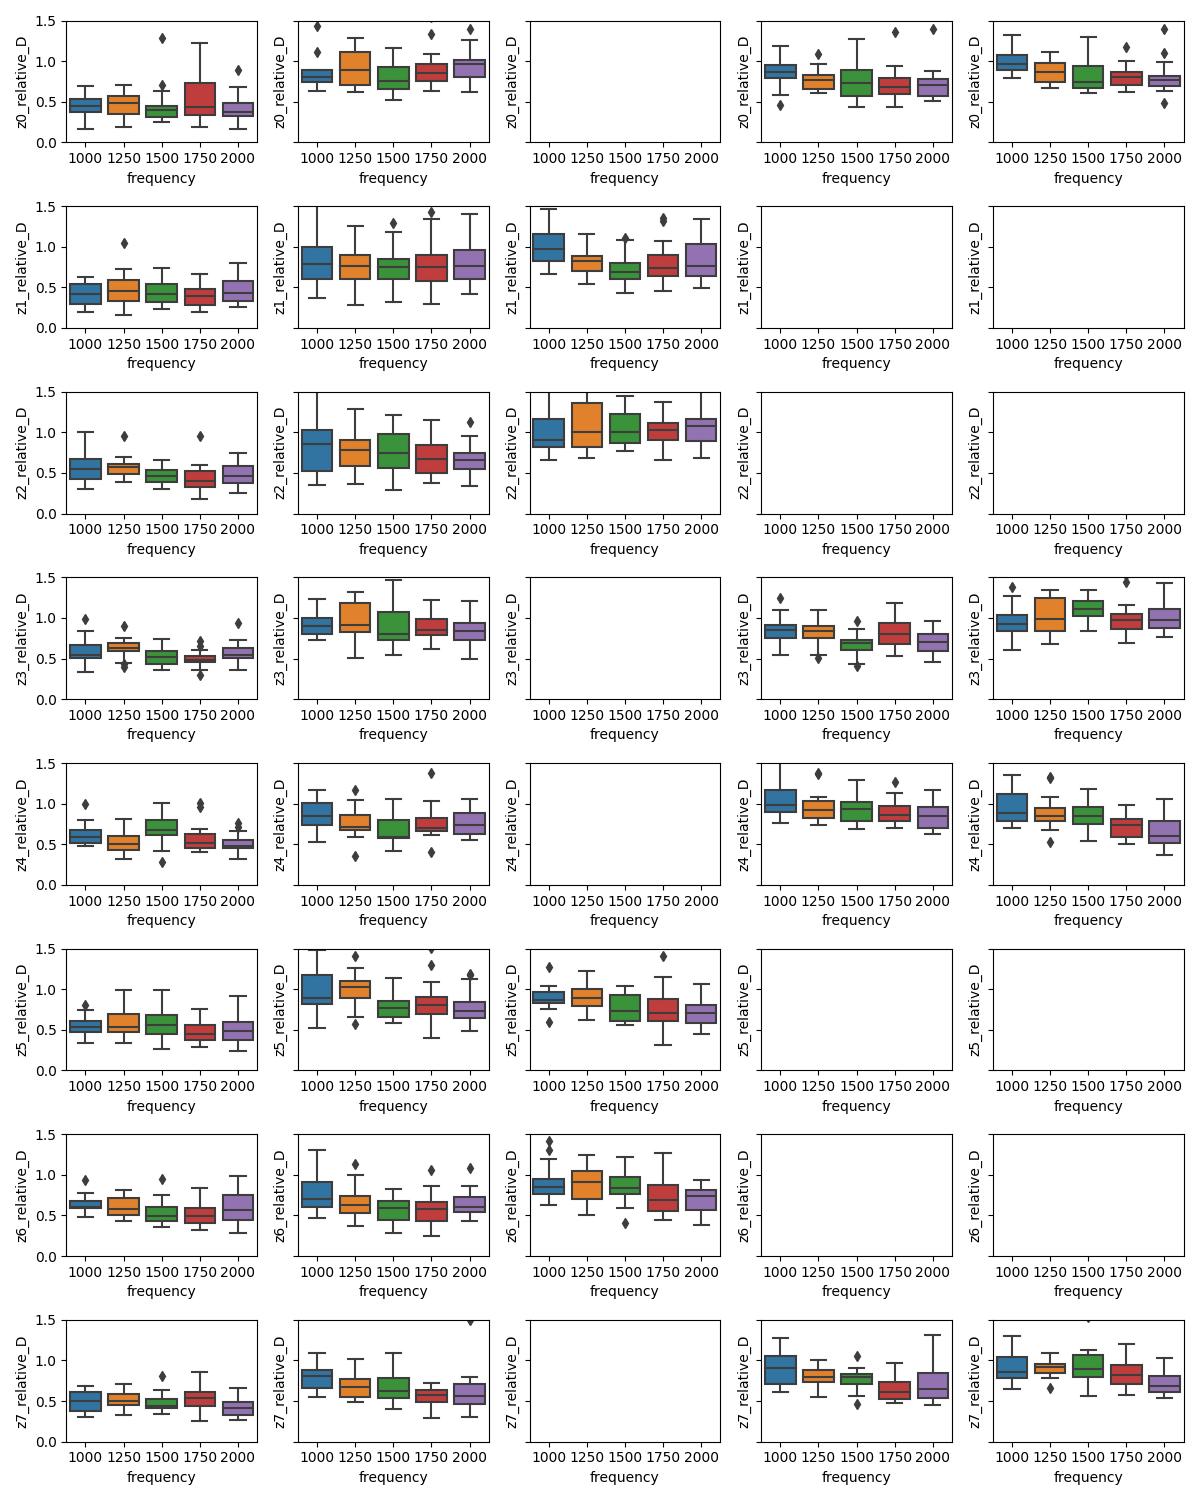

In [5]:
frequencies = [1000, 1250, 1500, 1750, 2000]
dist_to_act = [0, 1, 2, 4, 5]#, 9, 10]

dataset = data[data.nb_acts_active == 2]
fig, ax = matplotlib.pyplot.subplots(NB_ACTS, len(dist_to_act), figsize=(12, 15), sharey=True)
for act in range(NB_ACTS):
    ind = str(act)
    # data_act = data[data['act_z'+ind]==1]
    # data_noact = data[data['act_z'+ind]==0]

    for dist_id, dist in enumerate(dist_to_act):
        data_to_consider = dataset[dataset['act_z'+ind+'_closest_act_dist'] == dist]
        seaborn.boxplot(data=data_to_consider, y='z'+ind+'_relative_D', x='frequency', ax=ax[act, dist_id], order=frequencies)

ax[0,0].set_ylim([0, 1.5])
fig.tight_layout()

## 5 minutes analysis plots

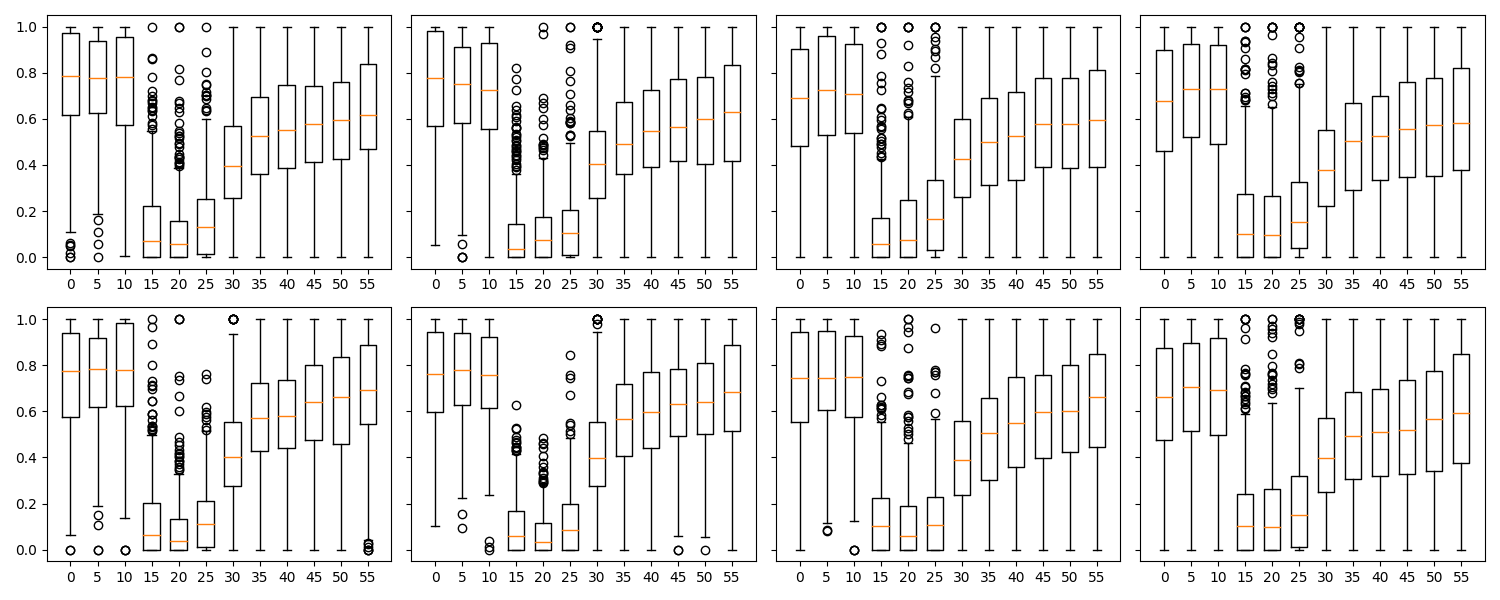

In [6]:
cmap = matplotlib.cm.get_cmap('rainbow') 

dataset = data[data.nb_acts_active == 4]
fig, ax = matplotlib.pyplot.subplots(2, 4, figsize=(15, 6), sharey=True)
for act in range(NB_ACTS):
    ind = str(act)
    # data_act = data[data['act_z'+ind]==1]
    # data_noact = data[data['act_z'+ind]==0]

    data_to_consider = dataset[dataset['act_z'+ind+'_closest_act_dist'] == 0]
    for j in range(-3, 9):
        # print(dataset)
        # print('z'+ind+'_bin'+str(j+3)+'_ave')
        ax[MAPPING[act][0], MAPPING[act][1]].boxplot(dataset['z'+ind+'_bin'+str(j+3)+'_rel'].values, positions=[(j+3)*5], widths=[3])#, c=cmap(float(j+3)/12), marker='+')
    # seaborn.boxplot(data=data_to_consider, y='z'+ind+'_relative_A2', x='frequency', ax=ax[act, dist_id], order=frequencies)
    
# ax[0,0].set_ylim([0, 1.5])
fig.tight_layout()

In [7]:
all_bins_vals

array([0.32682331, 0.96816194, 0.90072221, 0.31359984, 1.        ,
       0.        , 0.29274743, 0.02848133, 0.1991659 , 0.13477774,
       0.44461398, 0.38063269])

In [8]:
dataset.z0_bin0_ave

0      0.001390
4      0.003092
5      0.001280
8      0.003449
11     0.003179
         ...   
794    0.007046
798    0.008667
799    0.006652
802    0.004978
805    0.004940
Name: z0_bin0_ave, Length: 359, dtype: float64

In [9]:
dataset

,time,time_hr,frequency,trig0,trig1,act_z0,act_z1,act_z2,act_z3,act_z4,...,z7_bin2_rel,z7_bin3_rel,z7_bin4_rel,z7_bin5_rel,z7_bin6_rel,z7_bin7_rel,z7_bin8_rel,z7_bin9_rel,z7_bin10_rel,z7_bin11_rel
0,2023-05-28 08:00:12+00:00,230528T080012UTC,1750,8,8,0,0,0,0,1,...,0.666919,0.102551,0.000000,0.143419,0.307954,0.220465,0.233482,0.407477,0.760615,1.000000
4,2023-05-28 08:08:11+00:00,230528T080811UTC,2000,4,9,1,1,0,0,0,...,0.704920,0.105748,0.000000,0.142310,1.000000,0.670637,0.543035,0.850337,0.879026,0.553806
5,2023-05-28 08:10:11+00:00,230528T081011UTC,1750,8,3,0,0,1,1,1,...,0.521742,0.223420,0.000000,0.427633,0.137022,0.214281,0.339379,0.333881,0.108533,0.156730
8,2023-05-28 08:16:11+00:00,230528T081611UTC,1500,7,7,0,0,0,0,1,...,1.000000,0.154519,0.000000,0.160399,0.415493,0.220771,0.460960,0.178381,0.316833,0.456379
11,2023-05-28 09:02:11+00:00,230528T090211UTC,1250,1,1,1,1,1,1,0,...,0.452879,0.025468,0.029531,0.000000,0.021504,0.206223,0.202061,0.656625,0.215539,0.271529
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
794,2023-06-12 09:14:11+00:00,230612T091411UTC,1750,8,8,0,0,0,0,1,...,0.605562,0.093338,0.076979,0.000000,0.339816,0.424521,0.515072,0.483383,1.000000,0.996577
798,2023-06-12 10:02:12+00:00,230612T100212UTC,2000,4,9,1,1,0,0,0,...,1.000000,0.025257,0.030789,0.000000,0.337701,0.447065,0.553517,0.674127,0.782727,0.462096
799,2023-06-12 10:04:11+00:00,230612T100411UTC,1750,8,3,0,0,1,1,1,...,1.000000,0.053028,0.000000,0.151621,0.201713,0.479817,0.647706,0.749725,0.971193,0.789664
802,2023-06-12 10:10:11+00:00,230612T101011UTC,1500,7,7,0,0,0,0,1,...,0.970556,0.000000,0.157045,0.304554,0.481144,0.519327,0.333563,0.459823,0.457249,0.690732


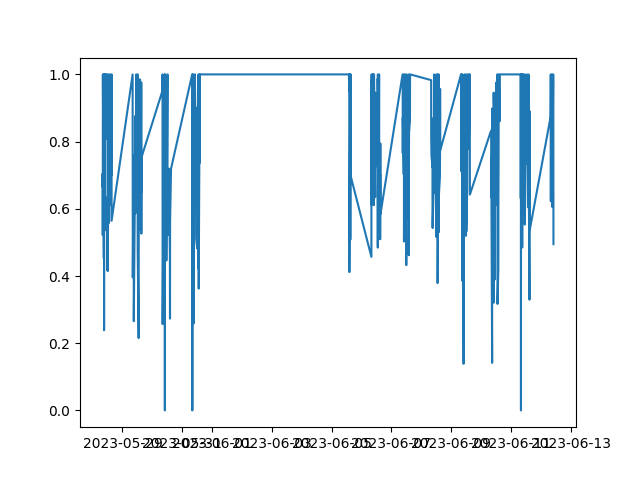

In [10]:
matplotlib.pyplot.figure()
matplotlib.pyplot.plot(dataset.time, dataset.z7_bin2_rel)

In [11]:
dataset.z7_bin2_rel.mean()

0.7676649469238129